In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(seed=23)

# Introduction

we are going to use simulations to calculate statistical power. We are going to use the experiment run by AirBnB using simultaneous reveal of reviews as loose inspiration. We will focus on the effect that simultaneous reveal had on the probability of a host leaving a review. 
Source: Reciprocity and Unveiling in Two-sided Reputation Systems: Evidence from an Experiment on Airbnb


Ultimately, we want to find the smallest sample size that AirBnB would have needed to prove that offering simultaneous review increases the probability that the host would leave a review. 


**Step 1**
- create simulated *random* samples for treatment and control, based on the parameters reported in the paper. 
- Use the proportion t-test from the statsmodels package to calculate whether or not we can reject the null hypothesis that treatment and control have the same proportion of hosts writing reviews
- Loop through this many times to see how often we reject the null hypothesis, when drawing different samples with the same proportions. 

**Step 2**
- we are going to try some alternative tools besides simulations to calculate power, besides the simulation.
- the power calculator from statsmodels.stats.power to calculate power and minimum sample size
- calculate the minimum sample size needed to maintain 80% power. 

**Step 3**-
- build a simualtion of step 1.
- allocate users between treatment and control to maximize power
- calculate “minimum detectable effect size” for a fixed population size

These types of calculations would be very similar to what you might do as an analyst or data scientist if you were planning a follow-up experiment to the paper described in the paper we read. You might take the results from that experiment as a starting point, and build on top of it.

# Simulating Power


In this question, we are going to calculate the statistical power of an experiment similar to the AirBnB simultaneous reveal experiment. However, we will begin by looking at what would have happened if they had a much smaller sample size, of only 100 users in each of the treatment and control cells


In [1]:
#A 
p_1 = 0.72
control_sample  = np.random.choice((0,1), p= [1-p_1, p_1], size = 100)
print(control_sample)

<IPython.core.display.Javascript object>

[0 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 1 0 1 0 1 1 1 1 1 1 0 1
 1 0 1 1 1 0 1 1 0 0 1 1 1 1 1 1 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 1 1 0 1 1 1
 1 0 1 1 1 0 0 1 1 0 0 1 1 1 1 1 1 1 0 0 1 1 0 1 0 0]


In [5]:
#B
total_rev = control_sample.sum()
total_rev

63

In [6]:
# C
def countReviews(p,n):
    control_sample = np.random.choice((0,1), p= [1-p, p], size = n)
    reviews = control_sample.sum()
    return reviews

In [7]:
# D
countReviews(0.79, 100)

<IPython.core.display.Javascript object>

91

Use the proportions_ztest function calculate the z-stat and the p-value. Using a two-sided test, test whether two means (from parts B and D) have the same proportion of host leaving a review. Can you reject the null hypothesis that they do, at 95% confidence 

In [8]:
from statsmodels.stats.proportion import proportions_ztest


In [10]:
#E
count = [total_rev, countReviews(0.79, 100)]
t_stat, p_val = proportions_ztest(count, 
                                  [100,100], 
                                  value=None, 
                                  alternative='two-sided', 
                                  prop_var=False)
print ("t-stat: ",round(t_stat,2), 
       "\nP-Value ", round(p_val,2))

def decision(confidence):
    if p_val < confidence:
        stat_sig = 1
    else:
        stat_sig =0 
    print (stat_sig)
    
decision(0.05)

<IPython.core.display.Javascript object>

t-stat:  -2.66 
P-Value  0.01
1


simulate what I did in part E 1000 times. 
- Make an empty list to keep track of your results
- Make a loop that will repeat 1000 times

Then, inside the loop
-  Use the function we created in C twice, once to draw a  control sample (72% chance of leaving a review ) and once to draw the treatment sample (79% chance of leaving a review). Both samples can have 100 hosts


In [ ]:
#F
p_sim = []
for x in range(1000):
    count = [countReviews(0.72, 100), countReviews(0.79, 100)]
    t_stat, p_val = proportions_ztest(count, 
                                  [100,100], 
                                  value=None, 
                                  alternative='two-sided', 
                                  prop_var=False)
    p_sim.append(p_val)

In [12]:
data = {'p_value': p_sim}
df = pd.DataFrame(data)
df["confidence"] = np.where(df['p_value'] < 0.05,1,0)
df.confidence.value_counts()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

0    786
1    214
Name: confidence, dtype: int64

In [13]:
df

,p_value,confidence
0,0.423072,0
1,0.005479,1
2,0.033895,1
3,0.025250,1
4,0.732807,0
...,...,...
995,0.003927,1
996,0.641818,0
997,0.736832,0
998,0.020453,1


In what percent of simulations from part F did we reject the null hypothesis?


In [14]:
#G 
100*(df.confidence.sum()/df.shape[0])

21.4

How does the percentage in part G relate to statistical power ?

We can see that we have rejected 20% of the random sample from two in F

# Calculating Power in Other Ways

Using *statsmodels.stats.power.zt_ind_solve_power* calculate the power of experiment using the same parameters used in part A. In particular we want:
- 95% confidence on a two-sided test
- 72% of hosts leaving reviews in treatment, 79% in control
- Assume a sample size of 100 in each cell

-  n = (Zα+Zβ)^2 * (p1(1-p1)+p2(1-p2)) / (p1-p2)^2
- For a two-sided t-test, you can use 1.96 for your critical for 95% confidence. you can use .84 as your critical value for 80% power


In [15]:
from statsmodels.stats.power import zt_ind_solve_power

In [16]:
#A
p_1 = 0.72
p_2 = 0.79
treatment = np.random.choice((0,1), p= [1-p_1, p_1], size = 100)
control   = np.random.choice((0,1), p= [1-p_2, p_2], size = 100)

p1 = treatment.mean()
p2 = control.mean()

def scale_effect(p1, p2):
    avg = (p1+ p2)/2
    st_dev = (avg*(1-avg))**(1/2)
    scaled = (p2 - p1)/st_dev
    return scaled

effect_size = scale_effect(p1, p2)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [19]:
# get the power
zt_ind_solve_power (effect_size = effect_size, nobs1= 100, alpha = .05)

0.20585550408180853

In [20]:
#B to get the number
zt_ind_solve_power (effect_size = effect_size, alpha = .05, power = .8)

608.607051205958

In [21]:
#C  
n = ((1.96+0.84)**2) * ((p1*(1-p1)+p2*(1-p2)) / (p1-p2)**2)
n

603.9999999999989

Testing Some Assumptions

**A (there are no points for this question. Doing this will make B,C,D easier)**: Take what we built to 1G and wrap it in a function. This means we should be running 1000 simulations, drawing from samples, and calculating whether you reject the null hypotheses in each simulation. 

we should have 4 arguments in this function, called “calc_power”. If should have 4 arguments 
- p_c:  Probability of host leaving a review when in control group
- p_t:  Probability of host leaving a review when in treatment group
- n_c = sample size for control
- n_t = sample size for treatment

This function should return the % of simulations where you reject the null hypothesis.



In [24]:
def calc_power(p_c, p_t, n_c, n_t):
    
    p_sim_power = []
    for x in range(10):
        control   = np.random.choice((0,1), p= [1-p_c, p_c], size = n_c)
        treatment = np.random.choice((0,1), p= [1-p_t, p_t], size = n_t)
        count = [control.sum(), treatment.sum()]
        t_stat, p_val = proportions_ztest(count, [n_c,n_t], value=None, alternative='two-sided', prop_var=False)

        p_sim_power.append(p_val)
    
        
    data = {'p_value': p_sim_power}
    df = pd.DataFrame(data)
    df["confidence"] = np.where(df['p_value'] < 0.05,1,0)
    df.confidence.value_counts()


    return 100*(df.confidence.sum()/df.shape[0])

In [26]:
print(calc_power(0.72, 0.79, 100, 100))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

30.0


See what happens as your sample sizes increases.  I’ve created a list of sample sizes below (n_obs). You should take this as your total sample size. So n_treatment and n_control should equal each value of n_obs divided by 2.  In part 2B and 2C, when we calculated sample size it was for one cell, but it is more common to know your entire addressable population and need to distribute it amongst cells. 
- Loop through sample sizes in n_obs. Capture power from each sample size
- Put n_obs and the output of your loop into a dataframe. Plot n_obs on the x-axis and power on the y-axis
- At what value of n_obs is power approximately equal to 80% (hint, this should be about double what you calculated in 2b and 2c). At what value is it approximately equal to 0.95


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

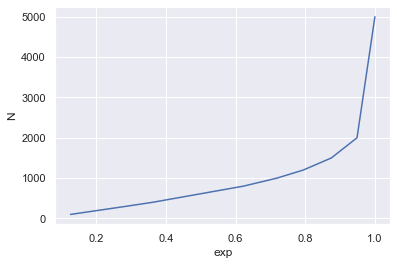

In [27]:
#B

n_obs = [100, 200, 300, 400, 800, 1000, 1200, 1500, 2000, 5000]
power = []
for x in n_obs:
    exp = zt_ind_solve_power (effect_size = effect_size, nobs1= x/2, alpha = .05)
    power.append(exp)
    

plot = {"N":n_obs, "exp": power}
df = pd.DataFrame(plot)
df

sns.set_theme(style="darkgrid")
sns.lineplot(data=df,x= df.exp, y= df.N)
plt.show()

Now, we examine what happens if you do not allocate equally to treatment and control. Assume we have a sample size of 2000 people total.  Simulate what would happen if 10% were in control and 90% were in treatment, 20% control/80% treatment, 30% control/70% treatment, etc. 
- Use the function you created in part 3.A to calculate power with different splits between treatment controls.
- Loop through percent_control  where  n_control should equal 2000*p and n_treatment should equal 2000*(1-p). 
- After you loop through thi, put both lists into a dataframe. Plot percent_treatment on the x-axis and power on the y axis. At what split between treatment and control is power maximized?

In [28]:
percents_control= np.linspace(.1,.9,9)
percents_control

<IPython.core.display.Javascript object>

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [29]:
def calc_power(p_c, p_t, n_c, n_t):
    percents_control = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    p_sim_power = []
    for x in percents_control:
        control   = np.random.choice((0,1), p= [1-p_c, p_c], size = int(n_c*x))
        treatment = np.random.choice((0,1), p= [1-p_t, p_t], size = int(n_t*(1-x)))
        count = [control.sum(), treatment.sum()]
        t_stat, p_val = proportions_ztest(count, [n_c,n_t], value=None, alternative='two-sided', prop_var=False)

        p_sim_power.append(p_val)
    

    data = {'p_value': p_sim_power}
    df = pd.DataFrame(data)
    df["confidence"] = np.where(df['p_value'] < 0.05,1,0)
    df.confidence.value_counts()


    return 100*(df.confidence.sum()/df.shape[0])      
calc_power(0.0, 0.9, 2000, 2000)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

100.0

In [ ]:
percents_control = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
g = []
for x in percents_control:
    s = calc_power(0.1,0.9, 2000,2000)
    g.append(s)

Now we want to learn for a fixed sample size, what the smallest effect size you will be powered to detect (at 95 percent confidence and 80% power).This is commonly referred to as the minimal detectable effect size. This is a common calculation when you know how many units you can potentially treat, and want to see if you would be powered to observe a result
- in this case we are going to keep our sample size at 2000 (n_c= 1000 and n_t=1000). We will keep the control treatment the same at .72. 
- Loop through different p_t’s from the  "ps_treatment" array provided below.
- What is the smallest p_t that produces more than 80% power? 
- What is the the minimum detectable effect size is for a population of 2000 (it should be value you just calculated - 0.72)


In [31]:
ps_treatment = np.arange(.725, .8,.005)
ps_treatment

<IPython.core.display.Javascript object>

array([0.725, 0.73 , 0.735, 0.74 , 0.745, 0.75 , 0.755, 0.76 , 0.765,
       0.77 , 0.775, 0.78 , 0.785, 0.79 , 0.795, 0.8  ])